In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
import torch.nn as nn
import time
from pyDOE import lhs
from functools import partial  # Higher-order functions and operations on callable objects
from pinns import *
from plotting import *
import warnings
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")


def f(model, x_f, y_f, A, k):
    # Concatenate x_f and y_f to form the input domain
    domain = torch.cat([x_f, y_f], dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Ensure the output has two columns for real and imaginary parts
    if u.shape[1] != 2:
        raise ValueError("The model output must have two columns for real and imaginary parts.")
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    return u_real, u_imag

def mse_f(model, x_f, y_f, A, k):
    u_real, u_imag = f(model, x_f, y_f, A, k)
    
    # Calcular la parte real e imaginaria de exp(-1j * k * x_f)
    ikx = -1j * k * x_f
    exp_ikx_top = torch.exp(ikx)
    exp_ikx_top_real = exp_ikx_top.real
    exp_ikx_top_imag = exp_ikx_top.imag
    
    # Calcular el error entre la salida del modelo y la función exponencial
    error_real = u_real - exp_ikx_top_real
    error_imag = u_imag - exp_ikx_top_imag
    
    # Calcular el error cuadrático medio
    mse = (error_real**2 + error_imag**2).mean()
    
    return mse

def closure(model, optimizer, x_f, y_f, A, k):
    optimizer.zero_grad()
    loss = mse_f(model, x_f, y_f, A, k)
    loss.backward(retain_graph=True)
    global iter
    iter += 1
    if iter % 100 == 0:
        print(f"LBFGS - Loss: {loss.item()}")
    return loss

def train_adam(model, x_f, y_f, A, k, num_iter=1_000):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    global iter
     
    for i in range(1, num_iter + 1):
        optimizer.zero_grad()
        loss = mse_f(model, x_f, y_f, A, k)  
        loss.backward(retain_graph=True)
        optimizer.step()
        iter += 1
        if iter % 100 == 0:
            print(f"Adam - Loss: {loss.item()}")

# Function for L-BFGS training
def train_lbfgs(model,x_f, y_f, A, k, num_iter=1_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, A, k)
    optimizer.step(closure_fn)
            
# Define the device
device = torch.device('cuda')

# Initialize iteration counter
iter = 0  

# Define the parameters
A = 1
k = 10

# Define lower and upper bounds for the domain
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])  

# Generate sampling points 
N_f = 2_000 

# Function to generate sampling points
def generate_sampling_points(lb, ub, N):
    c = lb + (ub - lb) * lhs(2, N)
    x = torch.from_numpy(c[:, 0]).float().reshape(-1, 1).to(device)
    x.requires_grad = True
    y = torch.from_numpy(c[:, 1]).float().reshape(-1, 1).to(device)
    y.requires_grad = True
    return x, y

x_f, y_f = generate_sampling_points(lb, ub, N_f)

# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=2, hidden_layers=5, hidden_units=100, activation_function=nn.Tanh()).to(device)
model.apply(init_weights)

train_lbfgs(model, x_f, y_f, A, k, num_iter=1000) 
               

In [50]:
def f(model, x_f, y_f, A, k):
    # Concatenate x_f and y_f to form the input domain
    domain = torch.cat([x_f, y_f], dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Ensure the output has two columns for real and imaginary parts
    if u.shape[1] != 2:
        raise ValueError("The model output must have two columns for real and imaginary parts.")
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    return u_real, u_imag

In [51]:
def mse_f(model, x_f, y_f, A, k):
    u_real, u_imag = f(model, x_f, y_f, A, k)
    
    # Calcular la parte real e imaginaria de exp(-1j * k * x_f)
    ikx = -1j * k * x_f
    exp_ikx_top = torch.exp(ikx)
    exp_ikx_top_real = exp_ikx_top.real
    exp_ikx_top_imag = exp_ikx_top.imag
    
    # Calcular el error entre la salida del modelo y la función exponencial
    error_real = u_real - exp_ikx_top_real
    error_imag = u_imag - exp_ikx_top_imag
    
    # Calcular el error cuadrático medio
    mse = (error_real**2 + error_imag**2).mean()
    
    return mse

In [52]:
def closure(model, optimizer, x_f, y_f, A, k):
    optimizer.zero_grad()
    loss = mse_f(model, x_f, y_f, A, k)
    loss.backward(retain_graph=True)
    global iter
    iter += 1
    if iter % 100 == 0:
        print(f"LBFGS - Loss: {loss.item()}")
    return loss

In [53]:
def train_adam(model, x_f, y_f, A, k, num_iter=1_000):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    global iter
     
    for i in range(1, num_iter + 1):
        optimizer.zero_grad()
        loss = mse_f(model, x_f, y_f, A, k)  
        loss.backward(retain_graph=True)
        optimizer.step()
        iter += 1
        if iter % 100 == 0:
            print(f"Adam - Loss: {loss.item()}")

In [54]:
# Function for L-BFGS training
def train_lbfgs(model,x_f, y_f, A, k, num_iter=1_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, A, k)
    optimizer.step(closure_fn)

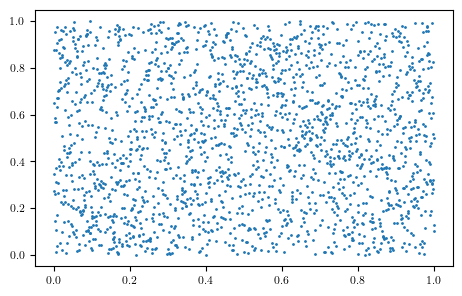

In [55]:
# Define the device
device = torch.device('cuda')

# Initialize iteration counter
iter = 0  

# Define the parameters
A = 1
k = 10

# Define lower and upper bounds for the domain
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])  

# Generate sampling points 
N_f = 2_000 

# Function to generate sampling points
def generate_sampling_points(lb, ub, N):
    c = lb + (ub - lb) * lhs(2, N)
    x = torch.from_numpy(c[:, 0]).float().reshape(-1, 1).to(device)
    x.requires_grad = True
    y = torch.from_numpy(c[:, 1]).float().reshape(-1, 1).to(device)
    y.requires_grad = True
    return x, y

x_f, y_f = generate_sampling_points(lb, ub, N_f)

# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=2, hidden_layers=5, hidden_units=100, activation_function=nn.Tanh()).to(device)
model.apply(init_weights)

# Function to plot sampling points
def plot_sampling_points(x, y, title):
    x_np = x.cpu().detach().numpy()
    y_np = y.cpu().detach().numpy()
    plt.scatter(x_np, y_np, s=1)
    
# Plot the sampling points
plot_sampling_points(x_f, y_f, 'Function Sampling Points')
plt.show()       
    

In [56]:
train_lbfgs(model, x_f, y_f, A, k, num_iter=1000)

In [57]:
# Número de muestras en x y y
dom_samples = 100
x = np.linspace(0, 1, dom_samples)
y = np.linspace(0, 1, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

def u_exact(x, y, k):
    ikx = -1j * x * k
    exp_ikx = np.exp(ikx)    
    return exp_ikx

In [58]:
# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1) 
U_pred = model(domain_ten)
U_real = U_pred[:, 0].detach().cpu().numpy().reshape(X.shape)

In [59]:
np.shape(U_real)

(100, 100)

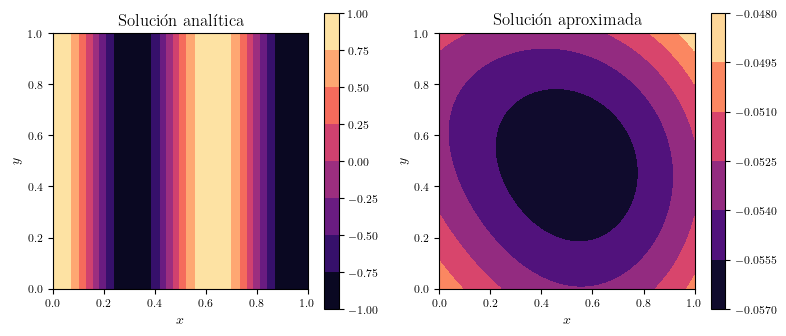

In [60]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, np.real(u_exact(X, Y,k)), cmap='magma')
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución analítica")
plt.axis("image")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, U_real, cmap='magma')
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución aproximada")
plt.axis("image")
plt.grid(False)

plt.tight_layout()